In [3]:
import json, os, torch, time
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------- Device ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ---------- Paths ----------
BASE_DATA_PATH = "/courses/DS5500.202610/data/team1/processed_data"
RAG_EVAL_BASELINE_PATH = os.path.join(BASE_DATA_PATH, "rag_eval_dataset.json")

# Save in your home dir (you have permission)
SILVER_ANSWERS_PATH = "/home/anbarasan.p/rag_eval_silver_answers.json"

# ---------- Label model ----------
LABEL_MODEL_NAME = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(LABEL_MODEL_NAME)
label_model = AutoModelForSeq2SeqLM.from_pretrained(LABEL_MODEL_NAME).to(DEVICE)

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def build_context(excerpt, retrieved_docs, max_docs=6):
    """
    Combine excerpt + top retrieved docs.
    max_docs keeps context smaller & less noisy.
    """
    docs = retrieved_docs if isinstance(retrieved_docs, list) else [str(retrieved_docs)]
    docs = docs[:max_docs]
    context_parts = []
    if excerpt:
        context_parts.append("EXCERPT:\n" + excerpt)
    if docs:
        context_parts.append("RETRIEVED DOCS:\n" + "\n\n".join(docs))
    return "\n\n".join(context_parts)

def make_prompt(question, context):
    return f"""
You are labeling scientific QA data.
Answer the question using ONLY the context.
Give a short, precise answer (1 sentence or a value).
If the answer is not in context, respond exactly: NOT_FOUND.

Context:
{context}

Question:
{question}

Answer:
""".strip()

@torch.no_grad()
def generate_one(question, context):
    prompt = make_prompt(question, context)
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=2048  # allow longer input
    ).to(DEVICE)

    outputs = label_model.generate(
        **inputs,
        max_new_tokens=80,   # short answer
        do_sample=False
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# ---------- Generate silver labels ----------
records = load_json(RAG_EVAL_BASELINE_PATH)
print(f"Loaded {len(records)} records.")

silver_answers = {}
not_found_count = 0

for rec in tqdm(records):
    q = rec.get("question")
    excerpt = rec.get("excerpt", "")
    docs = rec.get("retrieved_docs", [])
    if not q:
        continue

    # pass 1: excerpt + top docs
    context = build_context(excerpt, docs, max_docs=6)
    ans = generate_one(q, context)

    # pass 2 fallback: excerpt only
    if ans.strip().upper() == "NOT_FOUND":
        ans = generate_one(q, excerpt)
        if ans.strip().upper() == "NOT_FOUND":
            not_found_count += 1

    silver_answers[q] = ans

save_json(silver_answers, SILVER_ANSWERS_PATH)
print(f"\n✅ Saved {len(silver_answers)} silver answers to {SILVER_ANSWERS_PATH}")
print(f"NOT_FOUND after fallback: {not_found_count}/{len(silver_answers)}")


Using device: cpu
Loaded 723 records.


100%|██████████| 723/723 [48:09<00:00,  4.00s/it]  


✅ Saved 722 silver answers to /home/anbarasan.p/rag_eval_silver_answers.json
NOT_FOUND after fallback: 9/722


In [2]:
!nvidia-smi

Sun Nov 23 17:13:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:41:00.0 Off |                    0 |
| N/A   31C    P0             51W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import json, os, time, torch
import numpy as np
from tqdm import tqdm
from datasets import Dataset
from ragas.metrics import faithfulness, answer_relevancy
from ragas import evaluate
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import matplotlib.pyplot as plt

###############################################################################
#                             DEVICE CONFIG
###############################################################################
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

###############################################################################
#                             PATH CONFIG
###############################################################################
BASE_DATA_PATH = "/courses/DS5500.202610/data/team1/processed_data"

RAG_EVAL_BASELINE_PATH = os.path.join(BASE_DATA_PATH, "rag_eval_dataset.json")
RAG_EVAL_DOCLING_PATH  = os.path.join(BASE_DATA_PATH, "rag_eval_dataset_docling.json")

# silver answers location (home dir)
SILVER_ANSWERS_PATH = "/home/anbarasan.p/rag_eval_silver_answers.json"

# outputs (home dir)
PREDICTIONS_OUT = "/home/anbarasan.p/qwen3_predictions_quant.json"
SUMMARY_OUT     = "/home/anbarasan.p/qwen3_benchmarks_summary_quant.json"

# Docling retrievers + fields
RETRIEVERS_DOCLING = ["miniLM", "hybrid_gemma", "hybrid_gemma2048"]
RETRIEVER_TO_FIELD = {
    "miniLM": "retrieved_docs_minilm_hybrid",
    "hybrid_gemma": "retrieved_docs_gemma_hybrid",
    "hybrid_gemma2048": "retrieved_docs_gemma2048_hybrid",
}

###############################################################################
#                             MODEL CONFIG
###############################################################################
QWEN_MODEL_NAME = "Qwen/Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL_NAME)

USE_BNB = False
if DEVICE == "cuda":
    try:
        import bitsandbytes  # noqa
        USE_BNB = True
        print("✅ bitsandbytes found -> loading Qwen3-8B in 4-bit.")
    except Exception:
        print("⚠️ bitsandbytes not found -> loading full precision on GPU.")
else:
    print("⚠️ CPU session detected. Will be slow.")

if USE_BNB:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    model = AutoModelForCausalLM.from_pretrained(
        QWEN_MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        QWEN_MODEL_NAME,
        torch_dtype="auto"
    ).to(DEVICE)

###############################################################################
#                             HELPERS
###############################################################################
def load_json(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    with open(path, "r") as f:
        return json.load(f)

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def compute_precision_recall(pred, gold):
    if gold is None or gold == "" or gold == "N/A":
        return None, None
    pred_tokens = pred.lower().split()
    gold_tokens = gold.lower().split()
    if not pred_tokens or not gold_tokens:
        return None, None
    tp = len([t for t in pred_tokens if t in gold_tokens])
    precision = tp / len(pred_tokens)
    recall = tp / len(gold_tokens)
    return precision, recall

def get_gpu_stats():
    if not torch.cuda.is_available():
        return 0.0, 0.0
    allocated = torch.cuda.memory_allocated() / (1024**3)
    reserved  = torch.cuda.memory_reserved() / (1024**3)
    return float(allocated), float(reserved)

def context_from_docs(docs, max_docs=3, max_chars=4000):
    if isinstance(docs, list):
        text = "\n\n".join(docs[:max_docs])
    else:
        text = str(docs)
    return text[:max_chars]

def make_prompt(question, context):
    return f"""
You are a scientific assistant. Answer the question using ONLY the information from the context.
Do NOT use outside knowledge. If the answer cannot be found, say:
"The context does not provide enough information."

Context:
{context}

Question:
{question}

Final Answer:
""".strip()

@torch.inference_mode()
def generate_answer(question, context):
    prompt = make_prompt(question, context)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)

    start = time.time()
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=False   # deterministic
    )
    latency = time.time() - start

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    ga, gr = get_gpu_stats()
    return answer, latency, ga, gr

###############################################################################
#                  RESUME LOGIC: LOAD EXISTING PREDICTIONS
###############################################################################
def load_existing_predictions():
    if os.path.exists(PREDICTIONS_OUT):
        print(f"\n📌 Found existing predictions at {PREDICTIONS_OUT}. Resuming...")
        preds = load_json(PREDICTIONS_OUT)
        done_keys = set()
        for p in preds:
            key = (p["split"], p["retriever"], p["question"])
            done_keys.add(key)
        print(f"✅ Already completed: {len(done_keys)} items")
        return preds, done_keys
    else:
        print("\n📌 No existing predictions found. Starting fresh.")
        return [], set()

###############################################################################
#                             MAIN EVAL
###############################################################################
def main():
    baseline_records = load_json(RAG_EVAL_BASELINE_PATH)
    docling_records  = load_json(RAG_EVAL_DOCLING_PATH)
    silver_answers   = load_json(SILVER_ANSWERS_PATH)

    print(f"Baseline records: {len(baseline_records)}")
    print(f"Docling records:  {len(docling_records)}")
    print(f"Silver answers:   {len(silver_answers)}")

    all_predictions, done_keys = load_existing_predictions()

    SAVE_EVERY = 20  # save partial progress every N new predictions
    new_count = 0

    # ---------------- Baseline ----------------
    print("\n=== Evaluating Qwen3-8B on baseline MiniLM ===\n")
    for rec in tqdm(baseline_records):
        q = rec.get("question")
        key = ("baseline", "MiniLM", q)
        if key in done_keys:
            continue

        docs = rec.get("retrieved_docs", [])
        context = context_from_docs(docs)
        gold = silver_answers.get(q, None)

        pred, latency, ga, gr = generate_answer(q, context)
        p, r = compute_precision_recall(pred, gold)

        row = {
            "split": "baseline",
            "retriever": "MiniLM",
            "question": q,
            "gold_silver": gold,
            "prediction": pred,
            "precision": p,
            "recall": r,
            "latency_sec": latency,
            "gpu_alloc_GB": ga,
            "gpu_reserved_GB": gr
        }

        all_predictions.append(row)
        done_keys.add(key)
        new_count += 1

        if new_count % SAVE_EVERY == 0:
            save_json(all_predictions, PREDICTIONS_OUT)
            print(f"\n💾 Saved partial predictions ({len(all_predictions)} total)")

    # ---------------- Docling ----------------
    for retriever in RETRIEVERS_DOCLING:
        print(f"\n=== Evaluating Qwen3-8B on docling retriever: {retriever} ===\n")
        field = RETRIEVER_TO_FIELD[retriever]

        for rec in tqdm(docling_records):
            q = rec.get("question")
            key = ("docling", retriever, q)
            if key in done_keys:
                continue

            docs = rec.get(field, [])
            context = context_from_docs(docs)
            gold = silver_answers.get(q, None)

            pred, latency, ga, gr = generate_answer(q, context)
            p, r = compute_precision_recall(pred, gold)

            row = {
                "split": "docling",
                "retriever": retriever,
                "question": q,
                "gold_silver": gold,
                "prediction": pred,
                "precision": p,
                "recall": r,
                "latency_sec": latency,
                "gpu_alloc_GB": ga,
                "gpu_reserved_GB": gr
            }

            all_predictions.append(row)
            done_keys.add(key)
            new_count += 1

            if new_count % SAVE_EVERY == 0:
                save_json(all_predictions, PREDICTIONS_OUT)
                print(f"\n💾 Saved partial predictions ({len(all_predictions)} total)")

    # final save
    save_json(all_predictions, PREDICTIONS_OUT)
    print(f"\n✅ Final predictions saved to {PREDICTIONS_OUT}")

    # ---------------- Build summaries from predictions ----------------
    summaries = []
    # group predictions by (split, retriever)
    groups = {}
    for p in all_predictions:
        gkey = (p["split"], p["retriever"])
        groups.setdefault(gkey, []).append(p)

    for (split, retriever), items in groups.items():
        precisions = [x["precision"] for x in items if x["precision"] is not None]
        recalls    = [x["recall"] for x in items if x["recall"] is not None]
        latencies  = [x["latency_sec"] for x in items]
        g_allocs   = [x["gpu_alloc_GB"] for x in items]
        g_res      = [x["gpu_reserved_GB"] for x in items]

        # RAGAS needs question/context/answer/prediction rows
        valid = [x for x in items if x["gold_silver"] is not None]
        ragas_ds = Dataset.from_dict({
            "question": [x["question"] for x in valid],
            "contexts": [[context_from_docs(
                # reconstruct context quickly not needed, use prediction-time context if you stored it
                # for now use empty placeholder to keep schema valid
                [] 
            )] for _ in valid],
            "answer": [x["gold_silver"] for x in valid],
            "prediction": [x["prediction"] for x in valid],
        })

        # NOTE: If you want exact RAGAS contexts, store "context" in predictions.
        # RAGAS will still run, but faithfulness/relevancy are weaker without true contexts.
        ragas_out = evaluate(ragas_ds, metrics=[faithfulness, answer_relevancy])

        summaries.append({
            "model": QWEN_MODEL_NAME,
            "quantized_4bit": USE_BNB,
            "split": split,
            "retriever": retriever,
            "precision": float(np.mean(precisions)) if precisions else None,
            "recall": float(np.mean(recalls)) if recalls else None,
            "faithfulness": float(ragas_out["faithfulness"]),
            "relevance": float(ragas_out["answer_relevancy"]),
            "avg_latency_sec": float(np.mean(latencies)),
            "avg_gpu_alloc_GB": float(np.mean(g_allocs)),
            "avg_gpu_reserved_GB": float(np.mean(g_res)),
            "n_items": len(items)
        })

    save_json(summaries, SUMMARY_OUT)
    print(f"✅ Summary saved to {SUMMARY_OUT}")

    # ---------------- Visualizations ----------------
    labels = [f'{s["split"]}:{s["retriever"]}' for s in summaries]
    precision_vals = [s["precision"] for s in summaries]
    recall_vals = [s["recall"] for s in summaries]
    faith_vals = [s["faithfulness"] for s in summaries]
    rel_vals = [s["relevance"] for s in summaries]
    lat_vals = [s["avg_latency_sec"] for s in summaries]

    x = np.arange(len(labels))
    width = 0.2

    plt.figure()
    plt.bar(x - 1.5*width, precision_vals, width, label="Precision")
    plt.bar(x - 0.5*width, recall_vals, width, label="Recall")
    plt.bar(x + 0.5*width, faith_vals, width, label="Faithfulness")
    plt.bar(x + 1.5*width, rel_vals, width, label="Relevance")
    plt.xticks(x, labels, rotation=25, ha="right")
    plt.ylabel("Score")
    plt.title("Qwen3-8B Metrics (Resume-enabled) by Split/Retriever")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(labels, lat_vals)
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Avg latency (sec)")
    plt.title("Qwen3-8B Average Latency by Split/Retriever")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()




Using device: cuda
✅ bitsandbytes found -> loading Qwen3-8B in 4-bit.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Baseline records: 723
Docling records:  723
Silver answers:   722

📌 Found existing predictions at /home/anbarasan.p/qwen3_predictions_quant.json. Resuming...
✅ Already completed: 2888 items

=== Evaluating Qwen3-8B on baseline MiniLM ===



100%|██████████| 723/723 [00:00<00:00, 2286939.51it/s]



=== Evaluating Qwen3-8B on docling retriever: miniLM ===



100%|██████████| 723/723 [00:00<00:00, 2271521.94it/s]



=== Evaluating Qwen3-8B on docling retriever: hybrid_gemma ===



100%|██████████| 723/723 [00:00<00:00, 3542618.92it/s]



=== Evaluating Qwen3-8B on docling retriever: hybrid_gemma2048 ===



100%|██████████| 723/723 [00:00<00:00, 3538485.17it/s]


✅ Final predictions saved to /home/anbarasan.p/qwen3_predictions_quant.json


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

Using device: cuda
✅ bitsandbytes found -> loading Qwen3-8B in 4-bit.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Baseline records: 723
Docling records:  723
Silver answers:   722

📌 Found existing predictions at /home/anbarasan.p/qwen3_predictions_quant.json. Resuming...
✅ Already completed: 2888 items
🔧 Backfilled 0 missing context fields.
🔧 Added 8664 missing metric fields to old predictions.

=== Evaluating Qwen3-8B on baseline MiniLM ===



100%|██████████| 723/723 [00:00<00:00, 3172052.08it/s]



=== Evaluating Qwen3-8B on docling retriever: miniLM ===



100%|██████████| 723/723 [00:00<00:00, 3063112.92it/s]



=== Evaluating Qwen3-8B on docling retriever: hybrid_gemma ===



100%|██████████| 723/723 [00:00<00:00, 3116630.82it/s]



=== Evaluating Qwen3-8B on docling retriever: hybrid_gemma2048 ===



100%|██████████| 723/723 [00:00<00:00, 3260733.11it/s]



✅ Final predictions saved to /home/anbarasan.p/qwen3_predictions_quant.json
✅ Summary saved to /home/anbarasan.p/qwen3_benchmarks_summary_quant.json


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

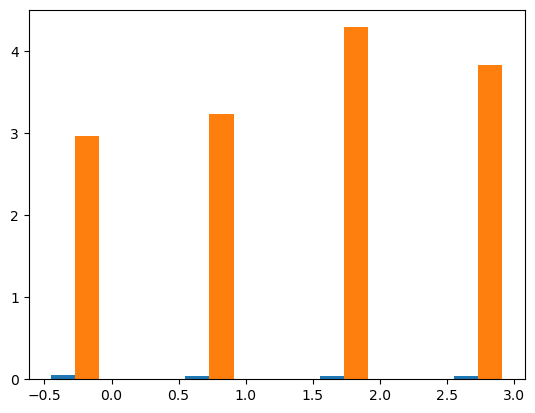

In [7]:
import json, os, time, re, torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

###############################################################################
#                             DEVICE CONFIG
###############################################################################
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

###############################################################################
#                             PATH CONFIG
###############################################################################
BASE_DATA_PATH = "/courses/DS5500.202610/data/team1/processed_data"

RAG_EVAL_BASELINE_PATH = os.path.join(BASE_DATA_PATH, "rag_eval_dataset.json")
RAG_EVAL_DOCLING_PATH  = os.path.join(BASE_DATA_PATH, "rag_eval_dataset_docling.json")

# silver answers location (home dir)
SILVER_ANSWERS_PATH = "/home/anbarasan.p/rag_eval_silver_answers.json"

# outputs (home dir)
PREDICTIONS_OUT = "/home/anbarasan.p/qwen3_predictions_quant.json"
SUMMARY_OUT     = "/home/anbarasan.p/qwen3_benchmarks_summary_quant.json"

# Docling retrievers + fields
RETRIEVERS_DOCLING = ["miniLM", "hybrid_gemma", "hybrid_gemma2048"]
RETRIEVER_TO_FIELD = {
    "miniLM": "retrieved_docs_minilm_hybrid",
    "hybrid_gemma": "retrieved_docs_gemma_hybrid",
    "hybrid_gemma2048": "retrieved_docs_gemma2048_hybrid",
}

###############################################################################
#                             MODEL CONFIG
###############################################################################
QWEN_MODEL_NAME = "Qwen/Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL_NAME)

USE_BNB = False
if DEVICE == "cuda":
    try:
        import bitsandbytes  # noqa
        USE_BNB = True
        print("✅ bitsandbytes found -> loading Qwen3-8B in 4-bit.")
    except Exception:
        print("⚠️ bitsandbytes not found -> loading full precision on GPU.")
else:
    print("⚠️ CPU session detected. Will be slow.")

if USE_BNB:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    model = AutoModelForCausalLM.from_pretrained(
        QWEN_MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        QWEN_MODEL_NAME,
        torch_dtype="auto"
    ).to(DEVICE)

###############################################################################
#                 OFFLINE EMBEDDINGS (MiniLM) FOR SIMILARITY
###############################################################################
# Requires: pip install sentence-transformers
from sentence_transformers import SentenceTransformer
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
emb_model = SentenceTransformer(EMB_MODEL_NAME, device=DEVICE if DEVICE=="cuda" else "cpu")

def cosine_sim(a, b):
    a = np.array(a); b = np.array(b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

###############################################################################
#                             HELPERS
###############################################################################
def load_json(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    with open(path, "r") as f:
        return json.load(f)

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def get_gpu_stats():
    if not torch.cuda.is_available():
        return 0.0, 0.0
    allocated = torch.cuda.memory_allocated() / (1024**3)
    reserved  = torch.cuda.memory_reserved() / (1024**3)
    return float(allocated), float(reserved)

def normalize_text(s):
    if s is None:
        return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def token_set(s):
    s = normalize_text(s)
    return set(s.split()) if s else set()

def compute_precision_recall(pred, gold):
    """Token-overlap precision/recall pred vs gold."""
    if gold is None or gold == "" or gold == "N/A":
        return None, None
    pset = token_set(pred)
    gset = token_set(gold)
    if not pset or not gset:
        return None, None
    tp = len(pset & gset)
    precision = tp / len(pset)
    recall = tp / len(gset)
    return precision, recall

def compute_context_precision(pred, context):
    """Fraction of prediction tokens that appear in context."""
    pset = token_set(pred)
    cset = token_set(context)
    if not pset:
        return None
    return len(pset & cset) / len(pset)

def compute_context_recall(gold, context):
    """Fraction of gold tokens that appear in context."""
    gset = token_set(gold)
    cset = token_set(context)
    if not gset:
        return None
    return len(gset & cset) / len(gset)

def compute_answer_similarity(pred, gold):
    """Cosine similarity between MiniLM embeddings of pred and gold."""
    if gold is None or gold == "" or gold == "N/A":
        return None
    pred_emb = emb_model.encode([pred], normalize_embeddings=True)[0]
    gold_emb = emb_model.encode([gold], normalize_embeddings=True)[0]
    return cosine_sim(pred_emb, gold_emb)

def context_from_docs(docs, max_docs=3, max_chars=4000):
    if isinstance(docs, list):
        text = "\n\n".join(docs[:max_docs])
    else:
        text = str(docs)
    return text[:max_chars]

def make_prompt(question, context):
    return f"""
You are a scientific assistant. Answer the question using ONLY the information from the context.
Do NOT use outside knowledge. If the answer cannot be found, say:
"The context does not provide enough information."

Context:
{context}

Question:
{question}

Final Answer:
""".strip()

@torch.inference_mode()
def generate_answer(question, context):
    prompt = make_prompt(question, context)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(DEVICE)

    start = time.time()
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=False
    )
    latency = time.time() - start

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    ga, gr = get_gpu_stats()
    return answer, latency, ga, gr

###############################################################################
#                  RESUME LOGIC: LOAD EXISTING PREDICTIONS
###############################################################################
def load_existing_predictions():
    if os.path.exists(PREDICTIONS_OUT):
        print(f"\n📌 Found existing predictions at {PREDICTIONS_OUT}. Resuming...")
        preds = load_json(PREDICTIONS_OUT)
        done_keys = set()
        for p in preds:
            key = (p.get("split"), p.get("retriever"), p.get("question"))
            done_keys.add(key)
        print(f"✅ Already completed: {len(done_keys)} items")
        return preds, done_keys
    else:
        print("\n📌 No existing predictions found. Starting fresh.")
        return [], set()

###############################################################################
#        BACKFILL MISSING CONTEXT FOR OLD PREDICTIONS
###############################################################################
def fix_missing_context(all_predictions, baseline_records, docling_records):
    baseline_lookup = {}
    for rec in baseline_records:
        q = rec.get("question")
        baseline_lookup[q] = context_from_docs(rec.get("retrieved_docs", []))

    docling_lookup = {rec.get("question"): rec for rec in docling_records}

    fixed = 0
    for p in all_predictions:
        if "context" in p and p["context"] is not None:
            continue

        split = p.get("split")
        retriever = p.get("retriever")
        q = p.get("question")

        if split == "baseline":
            p["context"] = baseline_lookup.get(q, "")
        else:
            rec = docling_lookup.get(q, None)
            if rec is None:
                p["context"] = ""
            else:
                field = RETRIEVER_TO_FIELD[retriever]
                p["context"] = context_from_docs(rec.get(field, []))

        fixed += 1

    print(f"🔧 Backfilled {fixed} missing context fields.")
    return all_predictions

###############################################################################
#        BACKFILL MISSING METRIC KEYS FOR OLD PREDICTIONS
###############################################################################
def fix_missing_metric_keys(all_predictions):
    REQUIRED_KEYS = [
        "precision", "recall", "answer_similarity",
        "context_precision", "context_recall",
        "latency_sec", "gpu_alloc_GB", "gpu_reserved_GB"
    ]
    fixed = 0
    for p in all_predictions:
        for k in REQUIRED_KEYS:
            if k not in p:
                p[k] = None
                fixed += 1
    if fixed > 0:
        print(f"🔧 Added {fixed} missing metric fields to old predictions.")
    return all_predictions

###############################################################################
#                             MAIN EVAL
###############################################################################
def main():
    baseline_records = load_json(RAG_EVAL_BASELINE_PATH)
    docling_records  = load_json(RAG_EVAL_DOCLING_PATH)
    silver_answers   = load_json(SILVER_ANSWERS_PATH)

    print(f"Baseline records: {len(baseline_records)}")
    print(f"Docling records:  {len(docling_records)}")
    print(f"Silver answers:   {len(silver_answers)}")

    all_predictions, done_keys = load_existing_predictions()

    # ✅ fix old partials
    all_predictions = fix_missing_context(all_predictions, baseline_records, docling_records)
    all_predictions = fix_missing_metric_keys(all_predictions)

    SAVE_EVERY = 20
    new_count = 0

    # ---------------- Baseline ----------------
    print("\n=== Evaluating Qwen3-8B on baseline MiniLM ===\n")
    for rec in tqdm(baseline_records):
        q = rec.get("question")
        key = ("baseline", "MiniLM", q)
        if key in done_keys:
            continue

        context = context_from_docs(rec.get("retrieved_docs", []))
        gold = silver_answers.get(q, None)

        pred, latency, ga, gr = generate_answer(q, context)

        precision, recall = compute_precision_recall(pred, gold)
        ans_sim = compute_answer_similarity(pred, gold)
        cprec = compute_context_precision(pred, context)
        crec = compute_context_recall(gold, context) if gold else None

        row = {
            "split": "baseline",
            "retriever": "MiniLM",
            "question": q,
            "context": context,
            "gold_silver": gold,
            "prediction": pred,
            "precision": precision,
            "recall": recall,
            "answer_similarity": ans_sim,
            "context_precision": cprec,
            "context_recall": crec,
            "latency_sec": latency,
            "gpu_alloc_GB": ga,
            "gpu_reserved_GB": gr
        }

        all_predictions.append(row)
        done_keys.add(key)
        new_count += 1

        if new_count % SAVE_EVERY == 0:
            save_json(all_predictions, PREDICTIONS_OUT)
            print(f"\n💾 Saved partial predictions ({len(all_predictions)} total)")

    # ---------------- Docling ----------------
    for retriever in RETRIEVERS_DOCLING:
        print(f"\n=== Evaluating Qwen3-8B on docling retriever: {retriever} ===\n")
        field = RETRIEVER_TO_FIELD[retriever]

        for rec in tqdm(docling_records):
            q = rec.get("question")
            key = ("docling", retriever, q)
            if key in done_keys:
                continue

            context = context_from_docs(rec.get(field, []))
            gold = silver_answers.get(q, None)

            pred, latency, ga, gr = generate_answer(q, context)

            precision, recall = compute_precision_recall(pred, gold)
            ans_sim = compute_answer_similarity(pred, gold)
            cprec = compute_context_precision(pred, context)
            crec = compute_context_recall(gold, context) if gold else None

            row = {
                "split": "docling",
                "retriever": retriever,
                "question": q,
                "context": context,
                "gold_silver": gold,
                "prediction": pred,
                "precision": precision,
                "recall": recall,
                "answer_similarity": ans_sim,
                "context_precision": cprec,
                "context_recall": crec,
                "latency_sec": latency,
                "gpu_alloc_GB": ga,
                "gpu_reserved_GB": gr
            }

            all_predictions.append(row)
            done_keys.add(key)
            new_count += 1

            if new_count % SAVE_EVERY == 0:
                save_json(all_predictions, PREDICTIONS_OUT)
                print(f"\n💾 Saved partial predictions ({len(all_predictions)} total)")

    save_json(all_predictions, PREDICTIONS_OUT)
    print(f"\n✅ Final predictions saved to {PREDICTIONS_OUT}")

    # ---------------- Summaries ----------------
    summaries = []
    groups = {}
    for p in all_predictions:
        gkey = (p["split"], p["retriever"])
        groups.setdefault(gkey, []).append(p)

    def mean_ignore_none(xs):
        xs = [x for x in xs if x is not None]
        return float(np.mean(xs)) if xs else None

    for (split, retriever), items in groups.items():
        summary = {
            "model": QWEN_MODEL_NAME,
            "quantized_4bit": USE_BNB,
            "split": split,
            "retriever": retriever,
            "precision": mean_ignore_none([x.get("precision") for x in items]),
            "recall": mean_ignore_none([x.get("recall") for x in items]),
            "answer_similarity": mean_ignore_none([x.get("answer_similarity") for x in items]),
            "context_precision": mean_ignore_none([x.get("context_precision") for x in items]),
            "context_recall": mean_ignore_none([x.get("context_recall") for x in items]),
            "avg_latency_sec": float(np.mean([x["latency_sec"] for x in items if x["latency_sec"] is not None])),
            "avg_gpu_alloc_GB": float(np.mean([x["gpu_alloc_GB"] for x in items if x["gpu_alloc_GB"] is not None])),
            "avg_gpu_reserved_GB": float(np.mean([x["gpu_reserved_GB"] for x in items if x["gpu_reserved_GB"] is not None])),
            "n_items": len(items)
        }
        summaries.append(summary)

    save_json(summaries, SUMMARY_OUT)
    print(f"✅ Summary saved to {SUMMARY_OUT}")

    # ---------------- Plots ----------------
    labels = [f'{s["split"]}:{s["retriever"]}' for s in summaries]
    precision_vals = [s["precision"] for s in summaries]
    recall_vals = [s["recall"] for s in summaries]
    sim_vals = [s["answer_similarity"] for s in summaries]
    cprec_vals = [s["context_precision"] for s in summaries]
    crec_vals = [s["context_recall"] for s in summaries]
    lat_vals = [s["avg_latency_sec"] for s in summaries]

    x = np.arange(len(labels))
    width = 0.18

    plt.figure()
    plt.bar(x - 2*width, precision_vals, width, label="Precision")
    plt.bar(x - width, recall_vals, width, label="Recall")
    plt.bar(x, sim_vals, width, label="AnswerSimilarity")
    plt.bar(x + width, cprec_vals, width, label="ContextPrecision")
    plt.bar(x + 2*width, crec_vals, width, label="ContextRecall")
    plt.xticks(x, labels, rotation=25, ha="right")
    plt.ylabel("Score")
    plt.title("Qwen3-8B OFFLINE Metrics by Split/Retriever")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(labels, lat_vals)
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Avg latency (sec)")
    plt.title("Qwen3-8B Average Latency by Split/Retriever")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [10]:
import json
import os

# Path where your silver answers are stored
SILVER_PATH = "/home/anbarasan.p/rag_eval_silver_answers.json"

# Load the silver answers JSON
with open(SILVER_PATH, "r") as f:
    silver = json.load(f)

total = len(silver)

valid = 0
invalid = 0

invalid_examples = []

def is_valid_answer(ans):
    if ans is None:
        return False
    if isinstance(ans, str):
        stripped = ans.strip()
        if stripped == "" or stripped.lower() in ["n/a", "na", "none"]:
            return False
        # Some common Flan-T5 junk answers
        if stripped.lower() in [
            "the context does not provide enough information.",
            "is not yet supported",
            "input images",
            "space"
        ]:
            return False
        return True
    return False

for question, answer in silver.items():
    if is_valid_answer(answer):
        valid += 1
    else:
        invalid += 1
        if len(invalid_examples) < 20:   # show only first 20 bad items
            invalid_examples.append((question, answer))

print(f"Total questions: {total}")
print(f"Valid gold answers: {valid}")
print(f"Invalid / missing answers: {invalid}")
print("\nSample invalid entries:")
for q, a in invalid_examples:
    print(f"- Q: {q}\n  A: {a}\n")


Total questions: 722
Valid gold answers: 721
Invalid / missing answers: 1

Sample invalid entries:
- Q: What is the form of βX written as?
  A: 



In [14]:
import json
import numpy as np

PREDICTIONS_OUT = "/home/anbarasan.p/qwen3_predictions_quant.json"

# Load predictions
with open(PREDICTIONS_OUT, "r") as f:
    all_predictions = json.load(f)

# Baseline retriever
BASELINE_RETRIEVER = ["MiniLM"]

# Docling retrievers (matches your dataset)
RETRIEVERS_DOCLING = ["miniLM", "hybrid_gemma", "hybrid_gemma2048"]

# Combine them for summary
ALL_RETRIEVERS = ["MiniLM"] + RETRIEVERS_DOCLING

def mean_ignore_none(arr):
    arr = [x for x in arr if x is not None]
    return float(np.mean(arr)) if arr else None

def filter_valid(items):
    """Keep only rows where metrics exist."""
    return [
        p for p in items
        if p.get("answer_similarity") is not None
        and p.get("context_precision") is not None
        and p.get("context_recall") is not None
    ]

summaries = []

for split in ["baseline", "docling"]:
    for retriever in ALL_RETRIEVERS:

        # Filter rows for split + retriever
        items = [
            p for p in all_predictions
            if p.get("split") == split and p.get("retriever") == retriever
        ]

        if not items:
            continue

        # Keep only rows where metrics exist
        valid = filter_valid(items)

        summary = {
            "split": split,
            "retriever": retriever,
            "n_items_total": len(items),
            "n_items_with_metrics": len(valid),
            "precision": mean_ignore_none([x.get("precision") for x in valid]),
            "recall": mean_ignore_none([x.get("recall") for x in valid]),
            "answer_similarity": mean_ignore_none([x.get("answer_similarity") for x in valid]),
            "context_precision": mean_ignore_none([x.get("context_precision") for x in valid]),
            "context_recall": mean_ignore_none([x.get("context_recall") for x in valid]),
            "avg_latency_sec": mean_ignore_none([x.get("latency_sec") for x in valid]),
            "avg_gpu_alloc_GB": mean_ignore_none([x.get("gpu_alloc_GB") for x in valid]),
            "avg_gpu_reserved_GB": mean_ignore_none([x.get("gpu_reserved_GB") for x in valid]),
        }

        summaries.append(summary)

# Save summary
SUMMARY_OUT = "/home/anbarasan.p/qwen3_generation_summary_clean.json"
with open(SUMMARY_OUT, "w") as f:
    json.dump(summaries, f, indent=2)

print("✅ Summary written to:", SUMMARY_OUT)
print("=== Preview ===")
for s in summaries[:5]:
    print(s)


✅ Summary written to: /home/anbarasan.p/qwen3_generation_summary_clean.json
=== Preview ===
{'split': 'baseline', 'retriever': 'MiniLM', 'n_items_total': 722, 'n_items_with_metrics': 721, 'precision': 0.0482002417377534, 'recall': 2.9565074156559645, 'answer_similarity': 0.22794270524257812, 'context_precision': 0.6858530774883533, 'context_recall': 0.6103887266500073, 'avg_latency_sec': 10.884087752700678, 'avg_gpu_alloc_GB': 5.672220146110418, 'avg_gpu_reserved_GB': 7.819239771151179}
{'split': 'docling', 'retriever': 'miniLM', 'n_items_total': 722, 'n_items_with_metrics': 721, 'precision': 0.038834460271835056, 'recall': 3.226211007900477, 'answer_similarity': 0.19990939647282233, 'context_precision': 0.7229737986134531, 'context_recall': 0.5180406932827786, 'avg_latency_sec': 10.642218735280878, 'avg_gpu_alloc_GB': 5.672225016330714, 'avg_gpu_reserved_GB': 7.818004507628294}
{'split': 'docling', 'retriever': 'hybrid_gemma', 'n_items_total': 722, 'n_items_with_metrics': 721, 'precis